In [ ]:
pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install komm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 3.2 MB/s 
  Created wheel for komm: filename=komm-0.7.1-py3-none-any.whl size=56608 sha256=c40bf6fe9ffa270d79a7fc34e6719ff29712402cf3536e155c40360f380410f3
  Stored in directory: /root/.cache/pip/wheels/67/d6/14/a8e4b0235b3dc3c8a28c4e2059b66ad5b8c262df15df54f843
Successfully built komm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
224/16

14.0

In [ ]:
import torch
import numpy as np
from torch import nn
from einops.layers.torch import Rearrange

import torchvision
from torchvision import transforms
import os
from tqdm import tqdm
import torch.optim as optim

import datetime
import os, sys
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn import preprocessing
from torch.utils.data import DataLoader
import komm
from torch.nn.functional import normalize

In [ ]:
obj = komm.QAModulation(16, base_amplitudes=1)
obj_QPSK = komm.PSKModulation(4,amplitude=1,phase_offset=np.pi/4)

In [ ]:
class FeedForward(nn.Module):
    def __init__(self,ConvTranspose2d dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class MixerBlock(nn.Module):

    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n d -> b d n'),
            FeedForward(num_patch, token_dim, dropout),
            Rearrange('b d n -> b n d')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            FeedForward(dim, channel_dim, dropout),
        )

    def forward(self, x):

        x = x + self.token_mix(x)

        x = x + self.channel_mix(x)

        return x

In [ ]:
class MLPMixer(nn.Module):

    def __init__(self, in_channels, dim, num_classes, patch_size, image_size, depth, token_dim, channel_dim):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) ** 2
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, patch_size, patch_size),
            Rearrange('b c h w -> b (h w) c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(MixerBlock(dim, self.num_patch, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)

        self.mlp_head = nn.Sequential(
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):


        x = self.to_patch_embedding(x)

        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x = self.layer_norm(x)

        x = x.mean(dim=1)

        return self.mlp_head(x)

In [ ]:
if __name__ == "__main__":
    img = torch.ones([1, 3, 224, 224])

    model = MLPMixer(in_channels=3, image_size=224, patch_size=16, num_classes=1000,
                     dim=512, depth=8, token_dim=256, channel_dim=2048)

    parameters = filter(lambda p: p.requires_grad, model.parameters())
    parameters = sum([np.prod(p.size()) for p in parameters]) / 1_000_000
    print('Trainable Parameters: %.3fM' % parameters)

    out_img = model(img)

    print("Shape of out :", out_img.shape)  # [B, in_channels, image_size, image_size]

Trainable Parameters: 18.528M
Shape of out : torch.Size([1, 1000])


In [ ]:
# Image resize 256
transform256 = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

# training set

trainset = torchvision.datasets.CIFAR10(root='traindata/', train=True,
                                        download=True, transform=transform256)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)
# test set
testset = torchvision.datasets.CIFAR10(root='testdata/', train=False,
                                       download=True, transform=transform256)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)
# cifar classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting traindata/cifar-10-python.tar.gz to traindata/


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting testdata/cifar-10-python.tar.gz to testdata/


In [ ]:
# MLP Mixer
mixer_model = MLPMixer(in_channels=3, 
                image_size=224, 
                patch_size=16, 
                num_classes=10,
                dim=512, 
                depth=8, 
                token_dim=256, 
                channel_dim=2048)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mixer_model.to(torch.device(device))
batch_size = 64
lr = 3e-4
n_epochs = 10

In [ ]:
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    print("Input:", inputs.shape)
    outputs = mixer_model(inputs)
    print(outputs)
    #if i == 1:
    #    break

In [ ]:
optimizer = torch.optim.Adam(mixer_model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()
def get_accuracy(preds, y):
    preds = preds.argmax(dim=1, keepdim=True)
    correct = preds.squeeze(1).eq(y)
    acc = correct.sum() / torch.FloatTensor([y.shape[0]]).to(device)
    return acc

In [ ]:
def loop(net, loader, is_train):
    net.train(is_train)
    losses = []
    accs = []
    pbar = tqdm(loader, total=len(loader))
    for x, y in pbar:
        x = x.to(device)
        y = y.to(device)
        with torch.set_grad_enabled(is_train):
            preds = net(x)
            loss = loss_fn(preds, y)
            acc = get_accuracy(preds, y)
            losses.append(loss.item())
            accs.append(acc.item())
        if is_train:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        pbar.set_description(f'epoch={epoch}, train={int(is_train)}')
        pbar.set_postfix(loss=f'{np.mean(losses):.4f}', acc=f'{np.mean(accs):.4f}')

In [ ]:
for epoch in range(n_epochs):
    loop(mixer_model, trainloader, True)
    loop(mixer_model, testloader, False)

In [ ]:
class NN_feedforward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LeakyReLU(0.5),
            #nn.Dropout(dropout),
            #nn.Linear(hidden_dim,hidden_dim),
            #nn.GELU(),#nn.LeakyReLU(0.3),
            nn.Linear(hidden_dim, dim),
            nn.LeakyReLU(0.5),
            #nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
class Patching_network(nn.Module):
    def __init__(self,patch_size):
        super().__init__()
        self.patch_net = nn.Sequential(
            nn.Conv1d(2,16,patch_size,patch_size)
        )
    def forward(self,x):
        x = self.patch_net(x)
        return x

In [ ]:
class CustomMixerBlock(nn.Module):

    def __init__(self, dim, num_patch, token_dim, channel_dim, dropout = 0.2):
        super().__init__()

        self.token_mix = nn.Sequential(
            nn.LayerNorm(dim),
            Rearrange('b n h w -> b h w n'),
            NN_feedforward(num_patch, token_dim, dropout),
            Rearrange('b h w n -> b n h w')
        )

        self.channel_mix = nn.Sequential(
            nn.LayerNorm(dim),
            NN_feedforward(dim, channel_dim, dropout),
        )

    def forward(self, x):

        #x = x + self.token_mix(x)

        x = x + self.channel_mix(x)

        return x

In [ ]:
images =np.random.randn(32,12, 16)
images = images.astype(np.float32)
dataload = DataLoader(dataset=images, batch_size=8, shuffle=False)

In [ ]:

#mixer_block = CustomMixerBlock(dim=16,num_patch=12,token_dim=36,channel_dim=64)
#nn_ff = NN_feedforward(dim=16,hidden_dim=64)
#for img in dataload:
#    #Rearrange('b n d -> b d n')
#    y = nn_ff(img)
#    print(y.shape)
#    break

In [ ]:
class CustomMLPMixer(nn.Module):

    def __init__(self, in_channels, dim, patch_size, image_size, depth, token_dim, channel_dim):
        super().__init__()

        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        self.num_patch =  (image_size// patch_size) # removing the squaring the factor as this is already one dimensional patch data at core.
        self.to_patch_embedding = nn.Sequential(
            nn.Conv2d(in_channels, dim, (patch_size,2), patch_size),
            Rearrange('b c h w -> b h w c'),
        )

        self.mixer_blocks = nn.ModuleList([])

        for _ in range(depth):
            self.mixer_blocks.append(CustomMixerBlock(dim, self.num_patch, token_dim, channel_dim))

        self.layer_norm = nn.LayerNorm(dim)
        self.deconv_layer = nn.Sequential(
            Rearrange('b h w c -> b c h w'),
            nn.ConvTranspose2d(in_channels=dim, out_channels=1,kernel_size=(patch_size,2), stride=patch_size),
            nn.Tanh()
        )


        self.mlp_head = nn.Sequential(
            nn.Linear(dim, image_size)
        )

    def forward(self, x):


        x = self.to_patch_embedding(x)

        for mixer_block in self.mixer_blocks:
            x = mixer_block(x)

        x_prev = self.layer_norm(x)
        x = self.deconv_layer(x_prev)

        x = x[:,0,:,0] + 1j*x[:,0,:,1]

        #x = x.mean(dim=1)
        return x

        #return self.mlp_head(x)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
load_data = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/NewQPSKdata/QPSK_rx_symbols.mat')
load_orig_data_dist = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/NewQPSKdata/QPSK_rx_symbol_labels.mat')

load_test_data = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/NewQPSKdata/QPSK_rx_symbols_test.mat')
load_orig_test_data_dist = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/NewQPSKdata/QPSK_rx_symbol_labels_test.mat')


load_bits = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/THz_dat/trainbits_qpsk.mat')

#-------------------------------

orig_data = load_orig_data_dist['rx_symbol_labels']
data = load_data['rx_symbols']

#-------------------------------

orig_test_data = load_orig_test_data_dist['rx_symbol_labels']
test_data = load_test_data['rx_symbols']

#-------------------------------

orig_bits = load_bits['trainbits']

#n_symbols = data.shape[1]
#n_symbols_chosen = 10000

#idx = np.random.choice(n_symbols,n_symbols_chosen,replace=False) #randomly choosing indexes to reduce load on RAM

#data = data[:,idx]
#orig_data = orig_data[:,idx]
idx1 = np.arange(0,96,2)
idx2 = np.arange(1,96,2)

#orig_data = orig_data[0:48,:] + 1j*orig_data[48:,:]

# the data is in 48 x N format
#train test split
split_idx = 13440#int(0.8*data.shape[1]) #approximating index for a 80:20 split so that it is divisible by 20(# of packets)

#Spliting as train and testing data
x_train = data#[:,0:split_idx]
x_test = test_data#[:,split_idx:]

#Transposing to N x 48 format
x_train = np.transpose(x_train)
x_test = np.transpose(x_test)

noisy_data = np.zeros([x_train.shape[0],1,48,2]) #Data preparation for Convolutional Neural network
noisy_data[:,0,:,0] = np.real(x_train[:,0:48])
noisy_data[:,0,:,1] = np.imag(x_train[:,0:48])
noisy_data = noisy_data.astype(np.float32)


noisy_test_data = np.zeros([x_test.shape[0],1,48,2]) #Test Data preparation for Convolutional Neural network
noisy_test_data[:,0,:,0] = np.real(x_test[:,0:48])
noisy_test_data[:,0,:,1] = np.imag(x_test[:,0:48])
noisy_test_data = noisy_test_data.astype(np.float32)
#Reshaping as (Nx12) x 4 format so that the network receives 4 symbols
#x_train = x_train.reshape(-1,4)
#x_test = x_test.reshape(-1,4) 

#x_train = np.matlib.repmat(x_train, 1, 6)
#x_test = np.matlib.repmat(x_test, 1, 6)


#.......................................#
train_labels = orig_data#[:,0:split_idx]
test_labels = orig_test_data#[:,split_idx:]

train_labels = np.transpose(train_labels)
test_labels = np.transpose(test_labels)


clean_data = np.zeros([train_labels.shape[0],1,2*train_labels.shape[1]])
clean_data[:,0,idx1] = np.real(train_labels)
clean_data[:,0,idx2] = np.imag(train_labels)
clean_data = clean_data.astype(np.float32)

clean_test_data = np.zeros([test_labels.shape[0],1,2*test_labels.shape[1]])
clean_test_data[:,0,idx1] = np.real(test_labels)
clean_test_data[:,0,idx2] = np.imag(test_labels)
clean_test_data = clean_test_data.astype(np.float32)

#train_labels = train_labels.reshape(-1,4)
#test_labels = test_labels.reshape(-1,4)

#train_labels = np.matlib.repmat(train_labels, 1, 6)
#test_labels = np.matlib.repmat(test_labels, 1, 6)
#.......................................#

tensor_x = torch.tensor(x_train, dtype=torch.complex64, device=device)
test_x = torch.tensor(x_test, dtype=torch.complex64, device=device)

train_labels_tensor = torch.tensor(train_labels, dtype=torch.complex64, device=device)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.complex64, device=device)

#--------------------------------#

noisy_train_data_loader = DataLoader(dataset=noisy_data, batch_size=20, shuffle=False)
clean_train_data_loader = DataLoader(dataset=train_labels_tensor, batch_size=20, shuffle=False)

noisy_test_data_loader = DataLoader(dataset=noisy_test_data, batch_size=20, shuffle=False)
clean_test_data_loader = DataLoader(dataset=test_labels_tensor, batch_size=20, shuffle=False)

#--------------------------------#

In [ ]:
test_noisy_data_tensor = torch.tensor(noisy_test_data, dtype=torch.float32, device=device)
#noisy_test_data

In [ ]:
print(noisy_data.shape)
print(noisy_test_data.shape)

(13440, 1, 96)
(3380, 1, 96)


In [ ]:
dataset_size

86760

In [ ]:
patch_size = 8

#p_net = Patching_network(patch_size=patch_size)
mixer_net = CustomMLPMixer(in_channels=1,dim=32,patch_size=1,image_size=48,depth=5,token_dim=16,channel_dim=256).to(device)
#optimD = optim.Adam([{'params': p_net.parameters()}], lr=1e-4, betas=(0.5, 0.99))
mixer_net_optim = optim.Adam([{'params':mixer_net.parameters()}],lr=1e-3)
n_epochs=150
loss = nn.MSELoss(reduction='none')#L1Loss(reduce=False)#
step = 0
def complex_mse(x,y):
    ls = loss(x.real,y.real)+1j*loss(x.imag,y.imag)
    return abs(ls)

In [ ]:
img = torch.ones([20, 1, 48, 2]).to(device)
out_img = mixer_net(img)
print("Shape of out :", out_img.shape)

Shape of out : torch.Size([20, 48])


In [ ]:
for idx,(x_clean,x_equalize) in enumerate(zip(clean_train_data_loader,noisy_train_data_loader)):
    x_clean = x_clean.to(device)
    x_equalize = x_equalize.to(device)
    y = mixer_net(x_equalize)
    mse_loss = loss(y,x_clean)
    print(mse_loss)
    break

In [ ]:
mse_loss.shape

torch.Size([4338, 2, 48])

In [ ]:
mse_losses = []
dataset_size = x_train.shape[0]
batch_size = 20
step_break = int(dataset_size/batch_size)
for epoch in range(n_epochs):
    mse_per_batch = []
    for idx,(x_clean,x_equalize) in enumerate(zip(clean_train_data_loader,noisy_train_data_loader)):
        step+=1
        x_clean = x_clean.to(device)
        x_equalize = x_equalize.to(device)

        mixer_net_optim.zero_grad()
        y = mixer_net(x_equalize)
        #print(x_equalize.shape)
        #print(y.shape)
        #break
        regularizer = 0
        nn_max_loss = torch.max(complex_mse(y,x_clean))
        #ls_max_loss =  torch.max(loss(x_equalize,x_clean))
        #if(nn_max_loss > ls_max_loss):
        #    regularizer = 0.1*nn_max_loss
        _loss = torch.mean(complex_mse(y,x_clean))
        
        mse_loss = _loss
        mse_loss.backward()
        mixer_net_optim.step()
        mse_per_batch.append(mse_loss.item())
        if step % step_break == 0:
            avg_mse_btch = np.mean(np.array(mse_per_batch))
            mse_losses.append(avg_mse_btch)
            #print(torch.max(_loss.reshape(-1)))
            print('Epoch: {}/{}, Step: {}, MSE loss: {}, NN_max loss: {}'\
                  .format(epoch,n_epochs,step,avg_mse_btch, nn_max_loss))

Epoch: 0/150, Step: 976, MSE loss: 0.047006854993849656, NN_max loss: 2.063089609146118
Epoch: 1/150, Step: 1952, MSE loss: 0.026693277737142692, NN_max loss: 2.1886281967163086
Epoch: 2/150, Step: 2928, MSE loss: 0.025390599518493113, NN_max loss: 2.1955747604370117
Epoch: 3/150, Step: 3904, MSE loss: 0.024860373648838592, NN_max loss: 2.1221325397491455
Epoch: 4/150, Step: 4880, MSE loss: 0.024541241434205597, NN_max loss: 2.018937826156616
Epoch: 5/150, Step: 5856, MSE loss: 0.02428495360283675, NN_max loss: 1.9649686813354492
Epoch: 6/150, Step: 6832, MSE loss: 0.024063603975905533, NN_max loss: 1.9692869186401367
Epoch: 7/150, Step: 7808, MSE loss: 0.02386718534464054, NN_max loss: 1.9827635288238525
Epoch: 8/150, Step: 8784, MSE loss: 0.02369974822470452, NN_max loss: 1.9783660173416138
Epoch: 9/150, Step: 9760, MSE loss: 0.02356798284078471, NN_max loss: 1.9815059900283813
Epoch: 10/150, Step: 10736, MSE loss: 0.023454665644857278, NN_max loss: 1.9931567907333374
Epoch: 11/150, 

In [ ]:
torch.max(loss(y,x_clean))

tensor(1.7031, device='cuda:0', grad_fn=<MaxBackward1>)

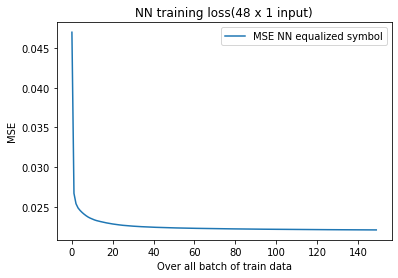

In [ ]:
mse_losses = np.array(mse_losses)
plt.plot(range(mse_losses.shape[0]),mse_losses[:],label='MSE NN equalized symbol')
plt.xlabel("Over all batch of train data")
plt.ylabel("MSE")
plt.title('NN training loss(48 x 1 input)')
plt.legend()

In [ ]:
_loss = loss(y,x_clean).view(-1)
#print(torch.max(_loss))
_loss = _loss.detach().to('cpu').numpy()

In [ ]:
#_loss = _loss.detach().to('cpu').numpy()
fig1, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(5,5))
ax1.set_title('Basic Plot')
b = ax1.boxplot(_loss,widths = 0.3, notch=True, showfliers=True, vert=False)
fig1.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/boxplot.png')

#plt.boxplot(_loss)
#fig = plt.figure(figsize=(100, 100))
#plt.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/boxplot.png')
#plt.show()

In [ ]:
print(_loss.shape)
print(b["fliers"][0].get_data()[1].shape)

(203904,)
(20448,)


In [ ]:
PATH = '/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/'+str(snr_)+'dB_model_weight'
torch.save(mixer_net.state_dict(), PATH)

In [ ]:
PATH = '/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/'+str(snr_)+'dB_model_weight'
mixer_net.load_state_dict(torch.load(PATH,map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
_load_mse_losses = []
_load_LS_mse_losses = []
test_loss = nn.MSELoss(reduction='none')
for idx,(x_clean_test,x_equalize_test) in enumerate(zip(clean_train_data_loader,noisy_train_data_loader)):
    step+=1
    x_clean_test = x_clean_test.to(device)
    x_equalize_test = x_equalize_test.to(device)

    #mixer_net_optim.zero_grad()
    y = mixer_net(x_equalize_test)
    #print(x_equalize.shape)
    #print(y.shape)
    #break
    _loss = test_loss(y,x_clean_test).view(-1)
    _loss = _loss.detach().to('cpu').numpy()
    _load_mse_losses.extend(_loss)

    _LS_mse_loss = test_loss(x_equalize_test,x_clean_test).view(-1)
    _LS_mse_loss = _LS_mse_loss.detach().to('cpu').numpy()
    _load_LS_mse_losses.extend(_LS_mse_loss)
    #mse_loss = torch.mean(_loss)
    #mse_loss.backward()
    #mixer_net_optim.step()
    #if step % step_break == 0:
    #mse_losses.append(mse_loss.item())
        #print(torch.max(_loss.reshape(-1)))
    #print('Step: {}, MSE loss: {}'\
    #     .format(step,mse_loss.item()))

_load_mse_losses = np.array(_load_mse_losses)
_load_LS_mse_losses = np.array(_load_LS_mse_losses)
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(snr_)+'dB.mat',mdict={'mse_loss_data': _load_mse_losses})
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(snr_)+'dB.mat',mdict={'ls_mse_loss_data': _load_LS_mse_losses})

In [ ]:
_5db_losses = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(5)+'dB.mat')['mse_loss_data']
_10db_losses = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(10)+'dB.mat')['mse_loss_data']
_15db_losses = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(15)+'dB.mat')['mse_loss_data']
_20db_losses = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(20)+'dB.mat')['mse_loss_data']
_25db_losses = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/mse_losses_'+str(25)+'dB.mat')['mse_loss_data']


_5db_losses_LS = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(5)+'dB.mat')['ls_mse_loss_data']
_10db_losses_LS = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(10)+'dB.mat')['ls_mse_loss_data']
_15db_losses_LS = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(15)+'dB.mat')['ls_mse_loss_data']
_20db_losses_LS = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(20)+'dB.mat')['ls_mse_loss_data']
_25db_losses_LS = sio.loadmat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/LS_mse_losses_'+str(25)+'dB.mat')['ls_mse_loss_data']

In [ ]:
print('NN med mean')
print(np.median(_5db_losses), np.mean(_5db_losses))
print(np.median(_10db_losses), np.mean(_10db_losses))
print(np.median(_15db_losses), np.mean(_15db_losses))
print(np.median(_20db_losses), np.mean(_20db_losses))
print(np.median(_25db_losses), np.mean(_25db_losses))

print('LS med mean')
print(np.median(_5db_losses_LS), np.mean(_5db_losses_LS))
print(np.median(_10db_losses_LS), np.mean(_10db_losses_LS))
print(np.median(_15db_losses_LS), np.mean(_15db_losses_LS))
print(np.median(_20db_losses_LS), np.mean(_20db_losses_LS))
print(np.median(_25db_losses_LS), np.mean(_25db_losses_LS))

In [ ]:
controls = ['5dB', '10dB', '15dB','20dB','25dB']
fig1, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(30,15))
ax1.set_title('Basic Plot')
b = ax1.boxplot([_5db_losses[0],_10db_losses[0],_15db_losses[0],_20db_losses[0],_25db_losses[0]],widths = 0.3, notch=True, showfliers=True, vert=False,labels=controls)
fig1.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/boxplot.png')

In [ ]:
controls = ['5dB', '10dB', '15dB','20dB','25dB']
fig1, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(30,15))
ax1.set_title('Basic Plot')
b = ax1.boxplot([_5db_losses_LS[0],_10db_losses_LS[0],_15db_losses_LS[0],_20db_losses_LS[0],_25db_losses_LS[0]],widths = 0.3, notch=True, showfliers=True, vert=False,labels=controls)
fig1.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/boxplot.png')

In [ ]:
print(_load_mse_losses.shape)
print(b["fliers"][0].get_data()[1].shape)
print(b["fliers"][0].get_data()[1].shape[0]/_load_mse_losses.shape[0])

(17694720,)
(1910460,)
0.1079678005642361


In [ ]:
recon_data = []
eq_symbols = []
orig_symbols = []

test_mse_loss = []
test_mse_loss_eq = []
#LS_eq_symbols = []
test_loss = nn.MSELoss(reduction='none')
for idx,(x_clean_test,x_equalize_test) in enumerate(zip(clean_test_data_loader,noisy_test_data_loader)):
    x_clean_test = x_clean_test.to(device)
    #LS_eq_symbols.extend(x_equalize_test[:,0,:]+1j*x_equalize_test[:,1,:])
    x_equalize_test = x_equalize_test.to(device)
    
    y_out = mixer_net(x_equalize_test)
    ls = torch.mean(complex_mse(y_out,x_clean_test))
    #eq_ls = torch.mean(test_loss(x_equalize_test,x_clean_test))

    test_mse_loss.append(ls.item())
    #test_mse_loss_eq.append(eq_ls.item())

    
    x_clean_test = x_clean_test.detach().to('cpu').numpy()
    x_equalize_test = x_equalize_test.detach().to('cpu').numpy()
    y_out = y_out.detach().to('cpu').numpy()

    x_clean_IQ = x_clean_test#[:,0,idx1]+1j*x_clean_test[:,0,idx2]
    x_equalize_IQ = x_equalize_test[:,0,:,0]+1j*x_equalize_test[:,0,:,1]
    y_out_IQ = y_out#[:,0,idx1]+1j*y_out[:,0,idx2]

    recon_bits = obj_QPSK.demodulate(received = y_out_IQ,decision_method='hard')
    orig_bits = obj_QPSK.demodulate(received = x_clean_IQ,decision_method='hard')
    eq_bits = obj_QPSK.demodulate(received = x_equalize_IQ,decision_method='hard')

    num_bits = orig_bits.shape[0]

    num_error = np.sum(recon_bits != orig_bits)

    num_error_eq = np.sum(eq_bits != orig_bits)
    print('NN MSE: {}'.format(ls.item()))
    print('NN ber: {}, LS ber: {}'\
                  .format((num_error/num_bits),(num_error_eq/num_bits)))
    recon = y_out_IQ#.detach().to('cpu').numpy()
    eq_symbols.extend(x_equalize_IQ)
    orig_symbols.extend(x_clean_IQ)

    #complex_recon = recon[:,0,:]+1j*recon[:,1,:]
    recon_data.extend(recon)

recon_data = np.asarray(recon_data)
eq_symbols = np.asarray(eq_symbols)
orig_symbols = np.asarray(orig_symbols)

test_mse_loss = np.array(test_mse_loss)
test_mse_loss_eq = np.array(test_mse_loss_eq)
#LS_val = noisy_test_data[:,0,:]+1j*noisy_test_data[:,1,:]
#clean_val = clean_test_data[:,0,:] +1j*clean_test_data[:,1,:]

NN MSE: 7.659957918804139e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 0.0014776777243241668
NN ber: 0.0, LS ber: 0.0
NN MSE: 0.0001862801582319662
NN ber: 0.0, LS ber: 0.0
NN MSE: 0.00012242505908943713
NN ber: 0.0, LS ber: 0.0
NN MSE: 9.209375275531784e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 3.0216762752388604e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 3.695995110319927e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 3.705354902194813e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 4.4887947296956554e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 4.693867958849296e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 2.57574920397019e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 2.7826014047604986e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 2.4801136532914825e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 2.370247420913074e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 2.539664819778409e-05
NN ber: 0.0, LS ber: 0.0
NN MSE: 0.07340843230485916
NN ber: 0.021875, LS ber: 0.0203125
NN MSE: 0.14860926568508148
NN ber: 0.0484375, LS ber: 0.04635416666666667
NN MSE: 0.0013339761644601822
NN

In [ ]:
out = mixer_net(test_noisy_data_tensor)
out = out#[:,0,idx1]+1j*out[:,0,idx2]
test_noisy_data_tensor = test_noisy_data_tensor[:,0,:,0]+1j*test_noisy_data_tensor[:,0,:,1]

In [ ]:
print(out.shape)
print(test_noisy_data_tensor.shape)

torch.Size([6820, 48])
torch.Size([6820, 48])


In [ ]:
print(out[5000])
print(test_noisy_data_tensor[5000])

tensor([ 0.7052-0.7012j, -0.7042+0.6990j, -0.6934-0.7118j, -0.6965+0.6474j,
         0.7059-0.6796j, -0.6939-0.7127j,  0.6743-0.1880j,  0.7100-0.7070j,
        -0.6936+0.5209j, -0.6268-0.6733j, -0.7034+0.6954j,  0.7094-0.7096j,
         0.6685+0.6914j,  0.7020-0.6948j,  0.7068-0.7038j,  0.6901+0.6979j,
        -0.6922-0.7117j, -0.7064+0.7035j,  0.7074-0.6993j, -0.6893-0.7114j,
        -0.6929-0.7120j, -0.6889-0.7113j, -0.7041+0.6978j,  0.7079-0.7049j,
        -0.7038+0.6966j, -0.7028+0.6933j,  0.6779+0.6945j,  0.7077-0.7024j,
         0.7047+0.7045j, -0.7023+0.6920j,  0.7090-0.7069j,  0.6995+0.7025j,
         0.7065-0.6962j,  0.6964+0.7012j,  0.7049+0.7046j, -0.7048+0.6999j,
        -0.6912-0.7118j, -0.7036+0.6961j,  0.7033+0.7037j, -0.6976-0.7126j,
        -0.6889-0.7113j, -0.7063+0.7041j,  0.6551+0.6619j,  0.7107-0.7097j,
         0.5131+0.3121j, -0.6926-0.7040j, -0.6946-0.7066j, -0.6253-0.6970j],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor([ 0.7886-0.4349j, -1.0582+0.6

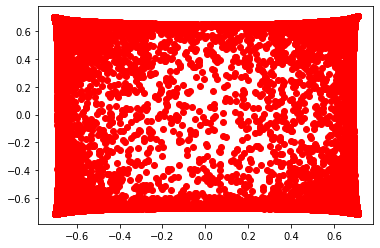

In [ ]:
out = out.detach().to('cpu').numpy()
X = [x.real for x in out]
Y = [x.imag for x in out]
plt.scatter(X,Y, color='red')

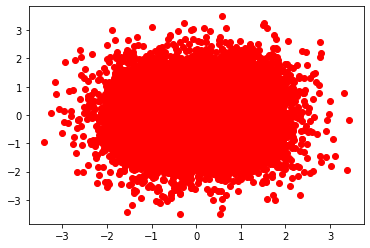

In [ ]:
test_noisy_data_tensor = test_noisy_data_tensor.detach().to('cpu').numpy()
X = [x.real for x in test_noisy_data_tensor]
Y = [x.imag for x in test_noisy_data_tensor]
plt.scatter(X,Y, color='red')

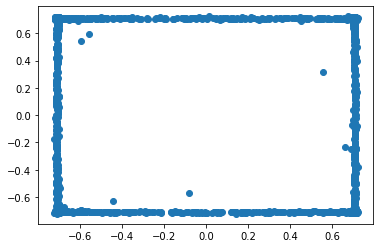

In [ ]:
plt.scatter(np.real(recon_data),np.imag(recon_data))

In [ ]:
xt = np.transpose(x_test)
x_recon = np.transpose(recon_data)
print(xt.shape)
print(x_recon.shape)

(48, 6820)
(48, 6820)


In [ ]:
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/thz_test_symbols.mat',mdict={'xt': xt})
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_QPSK_data/thz_recon_symbols.mat',mdict={'x_recon': x_recon})

In [ ]:
recon_data.shape

(34560, 48)

In [ ]:
recon_data = recon_data.reshape(-1)
eq_symbols = eq_symbols.reshape(-1)
orig_symbols = orig_symbols.reshape(-1)


orig_bits = obj_QPSK.demodulate(received=orig_symbols,decision_method='hard')
eq_bits = obj_QPSK.demodulate(received=eq_symbols,decision_method='hard')
recon_bits = obj_QPSK.demodulate(received=recon_data,decision_method='hard')

num_bits = len(orig_bits)

num_error_eq = np.sum(eq_bits != orig_bits)
print(num_error_eq/num_bits)

num_error = np.sum(recon_bits != orig_bits)
print(num_error/num_bits)

0.006384408602150538
0.006456195014662757


In [ ]:
idx = []
for i in range(num_bits):
    if(recon_bits[i] != orig_bits[i]) and (eq_bits[i] == orig_bits[i]):
        idx.append(i)

print(idx)

[2770, 28864, 28886, 29064, 29447, 29646, 29737, 29743, 30028, 30516, 30517, 30885, 31011, 31039, 31083, 31096, 31158, 31303, 31348, 31446, 31854, 31948, 31961, 32022, 32328, 32622, 42897, 43183, 43568, 46833, 52020, 52326, 52496, 52691, 52798, 55363, 55856, 56823, 58150, 58743, 58929, 59129, 59487, 59592, 59790, 61111, 61915, 62491, 62767, 63921, 65169, 65271, 65356, 65655, 65659, 65839, 66893, 67561, 68146, 68246, 68528, 68637, 68898, 68926, 71983, 75438, 75442, 88494, 88970, 89164, 89171, 89547, 90986, 90991, 92521, 92819, 93109, 93113, 93581, 94733, 95025, 95028, 95684, 99621, 100879, 101070, 101079, 101174, 101654, 104822, 105625, 105864, 105903, 105945, 106007, 106048, 106080, 106169, 106310, 106312, 106326, 106329, 106355, 106361, 106456, 106614, 106681, 106755, 106916, 107019, 107182, 107199, 107326, 107458, 107465, 108173, 108268, 111252, 111342, 114996, 115085, 117395, 117442, 118345, 118726, 119216, 119494, 120265, 120493, 120555, 120575, 120844, 121510, 121534, 121619, 1217

In [ ]:
print(recon_bits[2769:2772]) 
print(orig_bits[2769:2772])
print(eq_bits[2769:2772])

[1 1 0]
[1 0 0]
[1 0 0]


In [ ]:
print(recon_data[580:582])
print(eq_symbols[580:582]) 
print(orig_symbols[580:582])

[ 0.7083737 +0.6858903j -0.03764873-0.7155926j]
[0.8550404 +0.92604953j 0.07575124-0.6014512j ]
[0.70710677+0.70710677j 0.70710677-0.70710677j]


In [ ]:
print(recon_data[1384:1388])
print(eq_symbols[1384:1388]) 
print(orig_symbols[1384:1388])

[-0.704458  -0.7065191j  -0.44084343+0.70905244j -0.70859915+0.708374j
 -0.71040046-0.7091133j ]
[-1.259874  -0.6761349j   0.01753388+1.1095852j  -1.1051635 +0.9757316j
 -0.49550948-0.38228723j]
[-0.70710677-0.70710677j  0.70710677+0.70710677j -0.70710677+0.70710677j
 -0.70710677-0.70710677j]


(15552, 1)


<function matplotlib.pyplot.show>

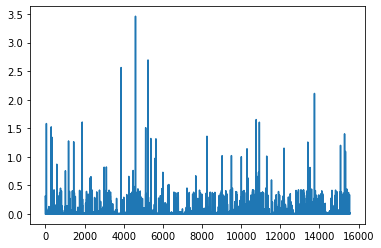

In [ ]:
test_loss = nn.MSELoss(reduction='none')
l = test_loss(y_out,x_clean_test)
l=l.detach().to('cpu').numpy()
l=l.reshape(-1,1)
print(l.shape)
plt.plot(range(l.shape[0]),l[:,0])
plt.show

In [ ]:
l[5500,0]

0.00019766322

In [ ]:
a = recon_data.reshape(-1,1)

In [ ]:
recon_bits = obj.demodulate(received=a[:,0],decision_method='hard')

In [ ]:
b = clean_val.reshape(-1,1)
c = LS_val.reshape(-1,1)

In [ ]:
a[86:89]

array([[ 0.01815498-0.32432482j],
       [-0.41054186+0.9585583j ],
       [-0.65374565+0.95595586j]], dtype=complex64)

In [ ]:
b[86:89]

array([[ 0.31622776-0.31622776j],
       [-0.31622776+0.9486833j ],
       [-0.31622776+0.9486833j ]], dtype=complex64)

In [ ]:
c[86:89]

array([[ 0.01606097-0.33154556j],
       [-0.39788905+1.0296724j ],
       [-0.6135443 +1.0527402j ]], dtype=complex64)

In [ ]:
orig_bits = obj.demodulate(received=b[:,0],decision_method='hard')
eq_bits = obj.demodulate(received=c[:,0],decision_method='hard')

In [ ]:
num_bits = orig_bits.shape[0]

In [ ]:
num_error_eq = np.sum(eq_bits != orig_bits)
print(num_error_eq/num_bits)

0.019344376929012346


In [ ]:
num_error = np.sum(recon_bits != orig_bits)
print(num_error/num_bits)

0.020293812692901234


In [ ]:
num_bits

6635520

In [ ]:
idx = []
for i in range(num_bits):
    if(recon_bits[i] != orig_bits[i]) and (eq_bits[i] == orig_bits[i]):
        idx.append(i)
        

In [ ]:
print(idx[0:16])

[352, 974, 2045, 2570, 2778, 2780, 3425, 3984, 4758, 4762, 4776, 5240, 5366, 5396, 5780, 5800]


In [ ]:
print(recon_bits[idx[0:16]])
print(eq_bits[idx[0:16]])
print(orig_bits[idx[0:16]])

[0 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0]
[1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1]
[1 1 1 0 0 1 0 0 1 0 0 1 1 1 1 1]


In [ ]:
print(recon_bits[0:350])
print(eq_bits[0:350])
print(orig_bits[0:350])

In [ ]:
num_bits = len(orig_bits[0:354])
num_error_eq = np.sum(eq_bits[0:354] != orig_bits[0:354])
print(num_error_eq/num_bits)

0.014124293785310734


In [ ]:
num_bits = len(orig_bits[0:354])
num_error = np.sum(recon_bits[0:354] != orig_bits[0:354])
print(num_error/num_bits)

0.014124293785310734


range(0, 345)


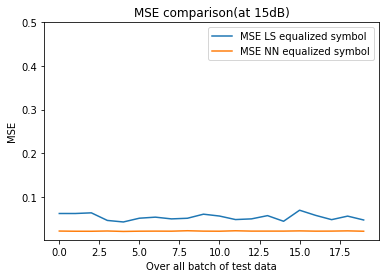

In [ ]:
plt.plot(range(test_mse_loss_eq.shape[0]),test_mse_loss_eq[:],label='MSE LS equalized symbol')
plt.plot(range(test_mse_loss.shape[0]),test_mse_loss[:], label='MSE NN equalized symbol')
plt.ylim([0.001, 0.5])
plt.xlabel("Over all batch of test data")
plt.ylabel("MSE")
plt.title('MSE comparison(at '+str(snr_)+'dB)')
plt.legend()
plt.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_16_QAM_data/'+str(snr_)+'dB_16QAM_MSE.png')
plt.show()


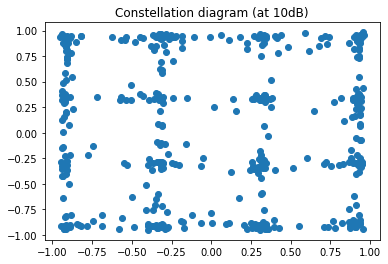

In [ ]:
plt.title('Constellation diagram (at '+str(snr_)+'dB)')
plt.scatter(np.real(recon_data[100:110]), np.imag(recon_data[100:110]))
plt.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_16_QAM_data/'+str(snr_)+'dB_16QAM_Constellation.png')

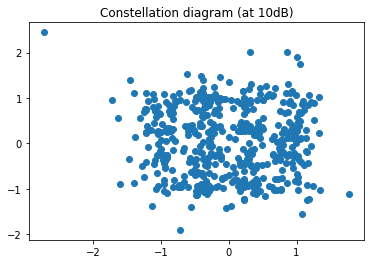

In [ ]:
plt.title('Constellation diagram (at '+str(snr_)+'dB)')
plt.scatter(np.real(LS_val[100:110]), np.imag(LS_val[100:110]))
plt.savefig('/content/drive/MyDrive/IQ_sample_data/GAN_16_QAM_data/'+str(snr_)+'dB_16QAM_Constellation_LS.png')

In [ ]:
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_16_QAM_data/recon_signal_'+str(snr_)+'dB.mat',mdict={'recon_data': recon_data})
sio.savemat('/content/drive/MyDrive/IQ_sample_data/GAN_16_QAM_data/original_val_signal_'+str(snr_)+'dB.mat',mdict={'clean_val': clean_val})

In [ ]:
x_clean_test[100,:,:]

tensor([[ 0.3162,  0.9487, -0.9487,  0.9487,  0.9487,  0.3162, -0.9487, -0.9487,
          0.9487,  0.3162, -0.3162, -0.3162, -0.3162, -0.9487, -0.3162,  0.3162,
         -0.3162, -0.9487, -0.3162, -0.9487,  0.3162,  0.3162, -0.9487,  0.9487,
          0.9487, -0.9487,  0.3162,  0.3162,  0.9487, -0.3162, -0.3162, -0.9487,
          0.3162, -0.3162,  0.3162,  0.3162, -0.9487,  0.3162,  0.9487, -0.9487,
         -0.3162,  0.9487,  0.9487, -0.9487,  0.9487, -0.3162,  0.3162, -0.3162],
        [ 0.9487, -0.9487,  0.9487, -0.9487, -0.3162,  0.3162,  0.3162, -0.3162,
          0.9487, -0.9487,  0.9487, -0.3162,  0.3162,  0.3162,  0.3162, -0.3162,
          0.9487, -0.3162,  0.9487, -0.3162, -0.9487, -0.3162, -0.9487,  0.9487,
          0.3162,  0.9487, -0.3162,  0.3162,  0.3162, -0.9487,  0.9487,  0.9487,
         -0.3162,  0.3162,  0.3162,  0.3162, -0.9487, -0.3162,  0.3162,  0.3162,
          0.3162,  0.9487,  0.3162,  0.9487,  0.9487,  0.9487,  0.9487,  0.3162]],
       device='cuda:0')

In [ ]:
x_equalize[400,:,:]

In [ ]:
y_out[100,:,:]

tensor([[ 0.3419,  0.9125, -0.8916,  0.9266,  0.9593,  0.2379, -0.9245, -0.9001,
          0.8961,  0.1726, -0.1694, -0.3905, -0.2356, -0.9862, -0.1940,  0.1286,
         -0.0905, -0.9753, -0.3089, -0.8785,  0.3511,  0.2707, -0.9330,  0.9266,
          0.9557, -0.9550,  0.4011,  0.3870,  0.9272, -0.2722, -0.2133, -0.8225,
          0.3241, -0.3229,  0.3132,  0.2969, -0.9491,  0.3875,  0.9634, -0.9242,
         -0.2948,  0.9639,  0.9761, -0.8726,  0.9291, -0.3189,  0.3241, -0.2501],
        [ 0.9091, -0.9540,  0.9502, -0.8927, -0.2147,  0.2168,  0.1023, -0.2548,
          0.9073, -0.8260,  0.9739, -0.3237,  0.1670,  0.4276,  0.4114, -0.5310,
          0.7326, -0.3235,  0.9406, -0.2748, -0.9776, -0.2195, -0.9229,  0.9351,
          0.2924,  0.9977, -0.3912,  0.7091,  0.4311, -0.8963,  0.9533,  0.8786,
         -0.3125,  0.3740,  0.3146,  0.2845, -0.9762, -0.2913,  0.3092,  0.3566,
          0.2198,  0.8790,  0.4054,  0.9743,  0.9414,  0.9284,  0.9699,  0.3350]],
       device='cuda:0', g

In [ ]:
for noisy in noisy_train_data_loader:
    out = p_net(noisy)
    print(out.shape)